In [1]:
#%matplotlib widget

import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from jacques import kcqe

# If in dark mode, uncomment the following line
plt.style.use('ggplot')

In [3]:
# Data generation adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# Fix random state for reproducibility
np.random.seed(19680801)

np.random.rand(5)

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

n = 500

#Create random predictors x0 and x1
x0 = randrange(n, -2. * np.pi, 2. * np.pi)
x1 = randrange(n, -2. * np.pi, 2. * np.pi)

#Create response variable y
y = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

In [4]:
#Combine x0 and x1 into a single data array of predictors
x = np.concatenate([x0[:, np.newaxis], x1[:, np.newaxis]], axis=1)

grid_size = 120

#Creates a grid of x values for test set
x_test = np.concatenate(
    [np.tile(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis],
        np.repeat(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis]],
    axis=1
)

In [5]:

# x_train_val
x = np.reshape(x, (1, 500, 2))
# y_train_val
y = np.reshape(y, (1, 500))

x_test = np.reshape(x_test, (1, 14400, 2))

x = tf.constant(x, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
    
block_size = 50
num_blocks = math.floor(y.shape[1]/block_size)

In [6]:
kcqe_obj = kcqe.KCQE(p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [7]:
x_val, x_train, y_val, y_train = next(generator)
print(x_val.shape)
print(y_val.shape)
print(x_train.shape)
print(y_train.shape)

(10, 50, 2)
(10, 50)
(10, 350, 2)
(10, 350)


In [8]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    init_param_vec=tf.constant(np.array([3.0, 3.0, 1.0]), dtype=tf.float32),
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[2.9000025 2.9000025 1.0999584]
loss = 
2.0183463
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.17697665,  0.18176882, -0.0077329 ], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[2.8006911 2.800357  1.199849 ]
loss = 
1.9624153
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.15188709,  0.16554002, -0.00752775], dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.7013772 2.7006097 1.2988794]
loss = 
1.9458532
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.15548837,  0.1724882 , -0.00642877], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[2.6027327 2.60045   1.396454 ]
loss = 
1.8843659
grads = 
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.13766149,  0.19335729, -0.00546689], dtype=float32

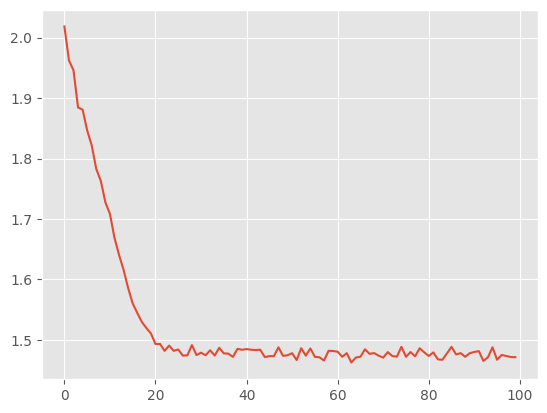

In [10]:
plt.plot(np.arange(len(kcqe_obj.loss_trace)), kcqe_obj.loss_trace)
plt.show()

In [11]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

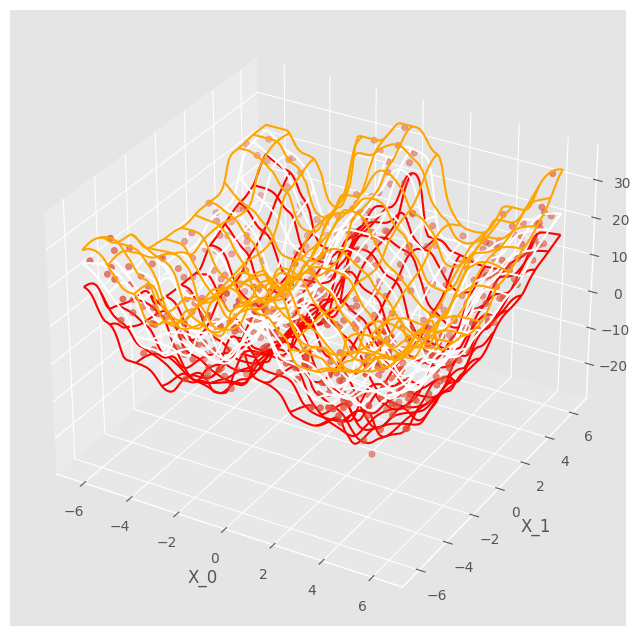

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

In [13]:
kcqe_obj = kcqe.KCQE(x_kernel='gaussian_full', p=2)
generator = kcqe_obj.generator(x, y, batch_size = 10, block_size = block_size)

In [14]:
# plug in generator instead of raw data to get away from calculating 7-day avg
# initialize parameters at some bad values; otherwise, convergence is instantaneous
param_vec = kcqe_obj.fit(xval_batch_gen = generator,
    num_blocks = num_blocks, 
    tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32),
    optim_method="adam", 
    num_epochs=10, 
    learning_rate=0.1,
    verbose = True)

epoch idx = 0
batch idx = 0
loss idx = 1
param estimates vec = 
[0.09999836 0.09999274 0.09998715 0.09953386]
loss = 
1.6402513
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.3250575 , -0.04792129, -0.02594887, -0.00067621], dtype=float32)>]
epoch idx = 0
batch idx = 1
loss idx = 1loss idx = 1
param estimates vec = 
[0.19958878 0.19301751 0.11481524 0.18942   ]
loss = 
1.6194605
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([-2.9279688e-01, -2.3657570e-02,  1.7156720e-02, -2.7801079e-04],
      dtype=float32)>]
epoch idx = 0
batch idx = 2
loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.29796183 0.2761684  0.08389858 0.27906877]
loss = 
1.5841627
grads = 
[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.24453256, -0.01080618,  0.02483328, -0.00130381], dtype=float32)>]
epoch idx = 0
batch idx = 3
loss idx = 1loss idx = 1loss idx = 1loss idx = 1
param estimates vec = 
[0.39443946 0.33660626 0.05513746 0.37005606]
loss = 
1.5639019
g

In [15]:
q_hat = kcqe_obj.predict(param_vec,
                         x_train=x,
                         y_train=y,
                         x_test=x_test,
                         tau=tf.constant(np.array([0.1, 0.5, 0.9]), dtype=tf.float32))

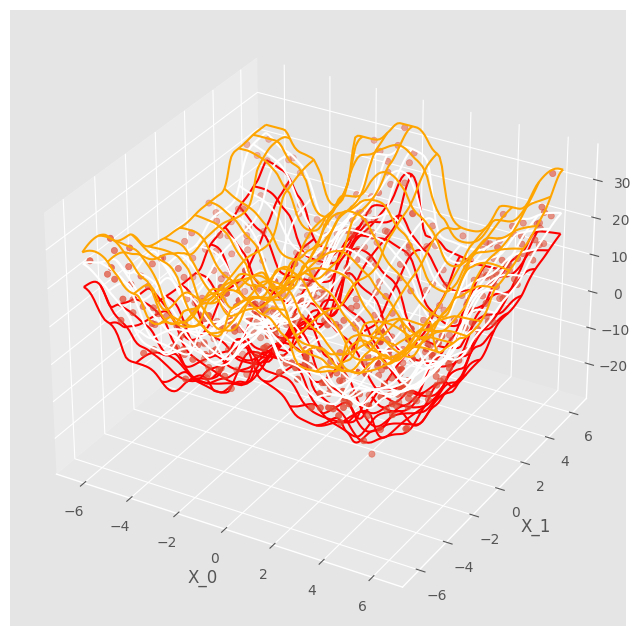

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()